# Hyperparameter Tuning

In this notebook the neural network hyperparameters are tuned by performing a grid search in subspace of the whole parameter space. Calculations are parallelized using ipyparallel.

The following hyperparameters are considered in the grid search:

- number of hidden layers
- number of neurons per layer
- batch size used during training
- adversarial training perturbation stength

In [1]:
import utils.config
import ipyparallel as ipp
c     = ipp.Client(profile='mpi')
lview = c.load_balanced_view()

In [2]:
%%px
%env KERAS_BACKEND=tensorflow
%env OMP_NUM_THREADS=1
import numpy as np
import matplotlib
matplotlib.use("Agg")

import sys
sys.path.insert(1, "/home/simonpf/src/typhon/")

from typhon.retrieval.qrnn import QRNN
from typhon.retrieval.scores import mean_quantile_score

[stdout:0] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:1] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:2] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:3] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:4] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:5] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:6] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:7] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:8] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:9] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:10] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:11] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:12] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:13] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:14] 
env: KERAS_BACKEND=tensorflow
env: OMP_NUM_THREADS=1
[stdout:15] 
env: KE

In [3]:
def train_model(config):
    
    quantiles = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
    depth, width, batch_size, delta_at = config
    
    x_train = np.load("/home/simonpf/projects/smhi/data/x_train.npy")
    y_train = np.load("/home/simonpf/projects/smhi/data/y_train.npy")
    x_val = np.load("/home/simonpf/projects/smhi/data/x_val.npy")
    y_val = np.load("/home/simonpf/projects/smhi/data/y_val.npy")
    
    n_val = x_val.shape[0] // 2
    x_val_1 = x_val[:n_val, :]
    x_val_2 = x_val[n_val:, :]
    y_val_1 = y_val[:n_val]
    y_val_2 = y_val[n_val:]
    
    n_trials = 2
    ql = np.zeros((n_trials, quantiles.size))
    
    for i in range(2):
        qrnn = QRNN(16, quantiles, depth, width, 'relu')
        qrnn.fit(x_train, y_train, sigma_noise = None,
                    adversarial_training = True,
                    delta_at = 0.1,
                    x_val = x_val_1,
                    y_val = y_val_1,
                    initial_learning_rate = 0.005,
                    batch_size = 128,
                    learning_rate_minimum = 1e-4,
                    learning_rate_decay = 2,
                    maximum_epochs = 500,
                    training_split = 0.75,
                    convergence_epochs = 0)
        
        qrnn_pred = qrnn.predict(x_val_2)
        ql[i, :] = mean_quantile_score(qrnn_pred, y_val_2, quantiles)
    return ql

In [6]:
configs = [(d, w, bs, dat) for d  in [2, 3, 4]
                      for w  in [64, 128, 256]
                      for bs in [128, 256]
                      for dat in [0.2, 0.1, 0.05]]
async_results = lview.map_async(train_model, configs)

In [9]:
import pickle
results = []
for i,r in enumerate(async_results):
    print("Config: " + str(configs[i]))
    print("Result: " + str(r))
    results += [(configs[i], r)]
    
with open('data/parameter_tuning_results.pkl', 'wb') as f:
       pickle.dump(results, f)

Config: (2, 64, 128, 0.2)
Result: [[ 14.03827236  23.72872943  36.19042932  42.47211043  45.31494962
   45.46560027  43.07652544  38.01688598  29.97137751  18.20913448
   10.51253624]
 [ 13.99110296  23.51597501  35.57233972  42.25342606  45.42656143
   45.3907022   42.61519592  37.45604864  29.63234227  18.0651168
   10.45542548]]
Config: (2, 64, 128, 0.1)
Result: [[ 14.09870487  23.61232567  35.18959325  41.6908936   45.05505361
   45.44089087  42.91806756  37.66615103  29.62794228  18.04023444
   10.48436808]
 [ 13.95750757  23.44161897  35.39833754  42.13232546  45.38521673
   45.5264439   42.9653737   37.80538305  29.79685913  18.09776821
   10.46000754]]
Config: (2, 64, 128, 0.05)
Result: [[ 13.92466615  23.51410234  35.62932656  42.05478225  45.28995666
   45.66644361  43.20688271  37.9646569   29.81585239  18.09915073
   10.46122834]
 [ 14.2271976   23.64890582  36.12331013  42.69274884  45.70766283
   45.95650195  43.41951118  37.96569397  29.71530332  18.10172046
   10.459294

KeyError: 25

In [10]:
with open('data/parameter_tuning_results.pkl', 'wb') as f:
       pickle.dump(results, f)

## Displaying the results

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
results = pickle.load(open("data/parameter_tuning_results.pkl", "rb"))
configs = [(d, w, bs, dat) for d  in [2, 3, 4]
                      for w  in [64, 128, 256]
                      for bs in [128, 256]
                      for dat in [0.2, 0.1, 0.05]]
loss   = np.array([b for (a, b) in results])

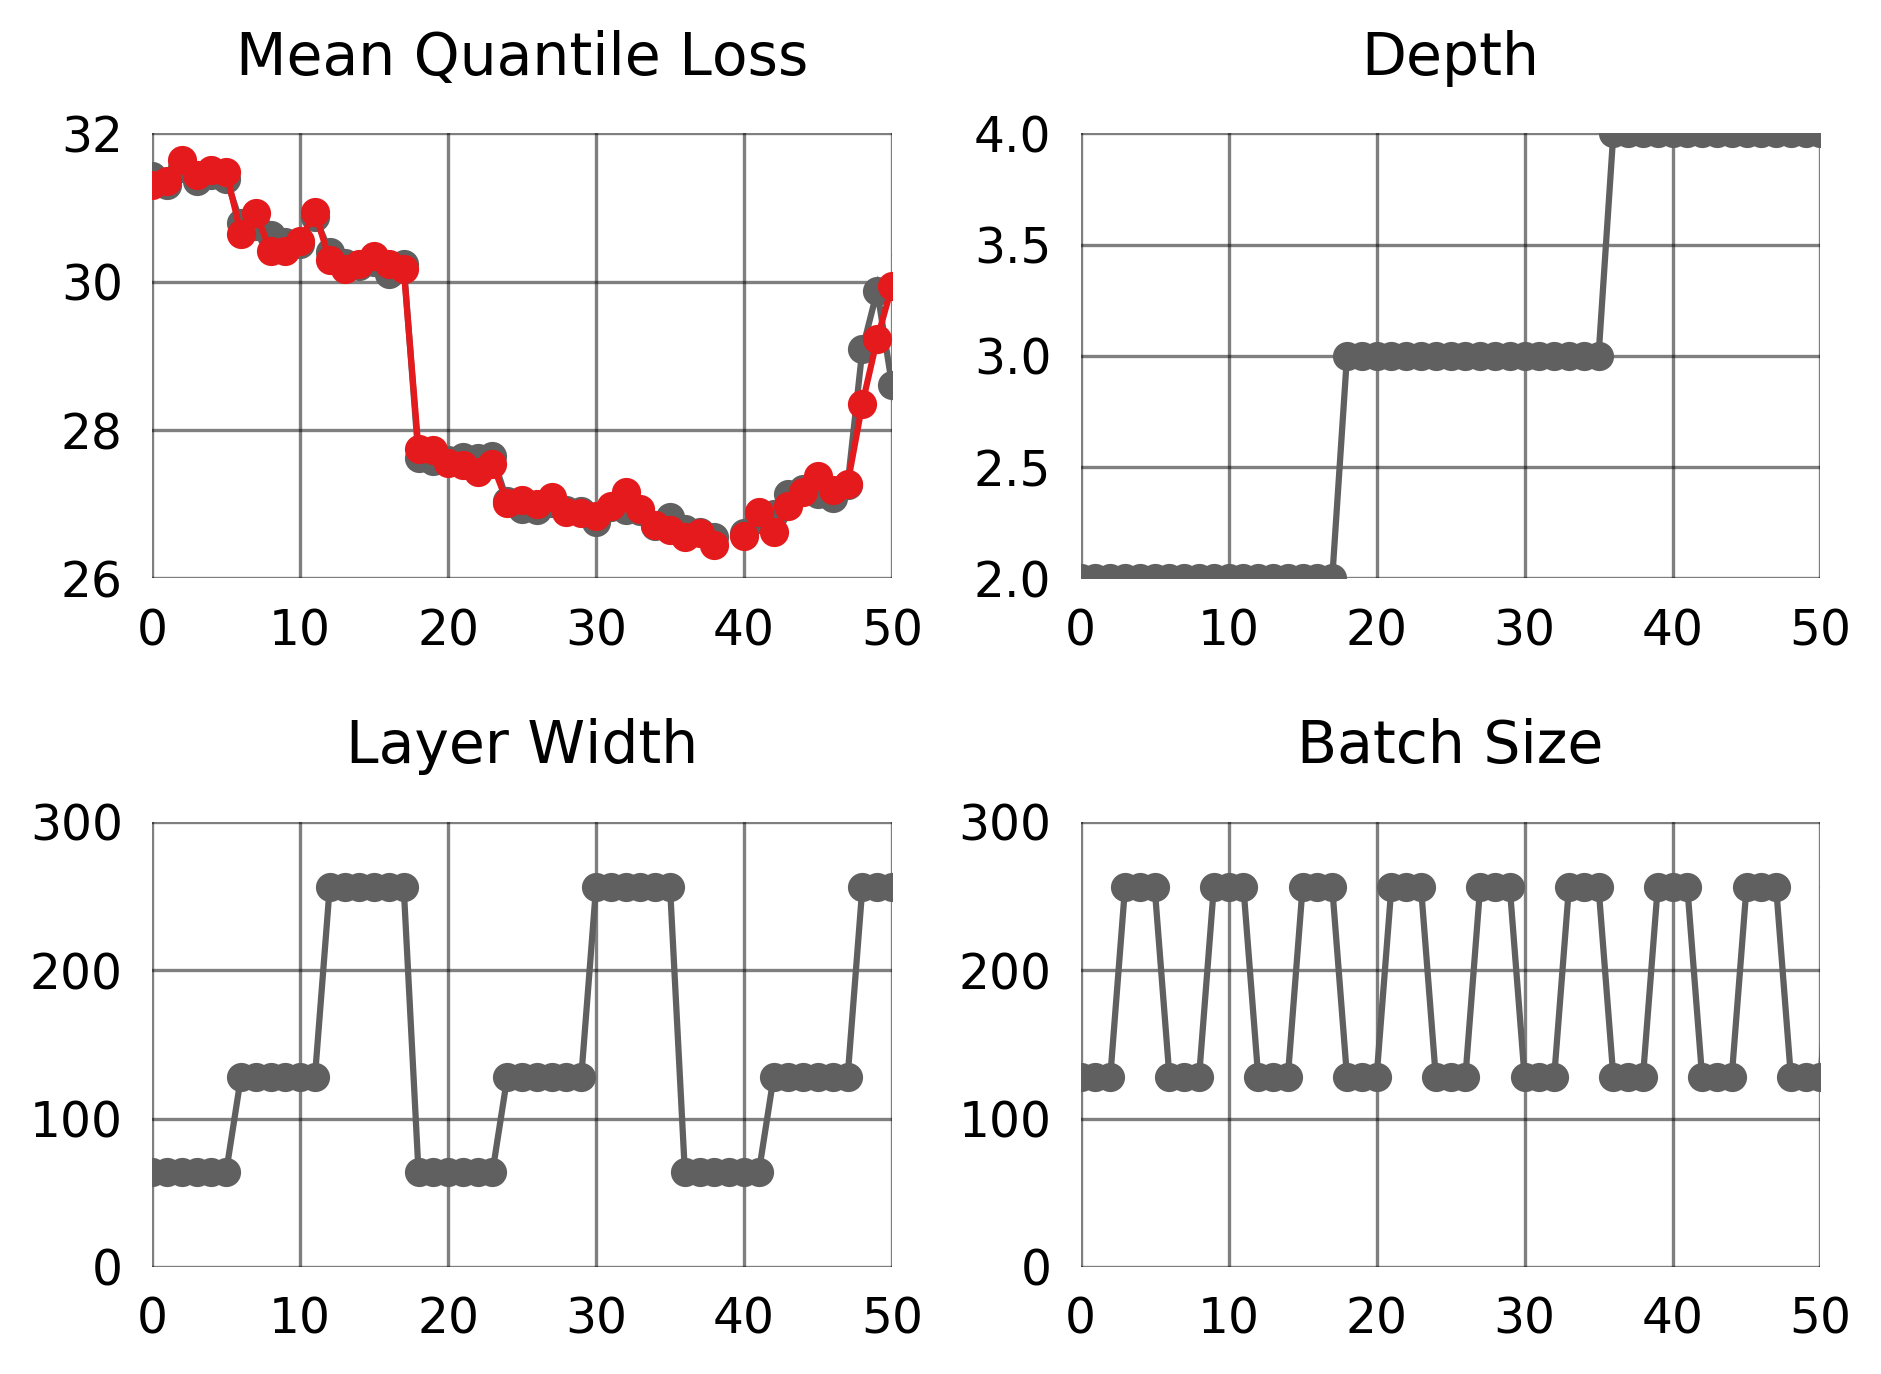

In [18]:
f, axs = plt.subplots(2, 2)
axs[0, 0].plot(np.mean(np.mean(loss, axis = 2), axis = 1), marker = 'o')
axs[0, 0].plot(np.mean(loss, axis = 2)[:, 1], marker = 'o')
axs[0, 0].set_xlim([0, 50])
axs[0, 0].set_ylim([26, 32])
axs[0, 0].set_title("Mean Quantile Loss")

layers = np.array([c[0] for c in configs])
axs[0, 1].plot(layers, marker = 'o')
axs[0, 1].set_xlim([0, 50])
axs[0, 1].set_title("Depth")
axs[0, 1].set_ylim([2, 4])

width = np.array([c[1] for c in configs])
axs[1, 0].plot(width, marker = 'o')
axs[1, 0].set_xlim([0, 50])
axs[1, 0].set_title("Layer Width")
axs[1, 0].set_ylim([0, 300])

bs = np.array([c[2] for c in configs])
axs[1, 1].plot(bs, marker = 'o')
axs[1, 1].set_xlim([0, 50])
axs[1, 1].set_title("Batch Size")
axs[1, 1].set_ylim([0, 300])

plt.tight_layout()